# Matching float profiles to satellite pixels
## Import Packages

In [187]:
import pandas as pd
import xarray as xr
import glob
from pyhdf.SD import SD,SDC
import numpy as np
from datetime import *
from FromBieito.soccom_functions import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Load in satellite data

In [20]:
rootdir = '../data/raw/cafe/'
files = sorted(glob.glob(rootdir+"/*.hdf"))
print(files)

fd=xr.open_dataset(files[0])
display(fd)

### Time is in matlab datenum 
= Need to convert to datetime

* Pos ask about how to put the values into the xarray dataset, but for now, is made as a separate variable (means a few extra lines later on)

In [38]:
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    return datetime.fromordinal(int(datenum)) \
           + timedelta(days=days) \
           - timedelta(days=366)

In [84]:
nz= len(fd.date.values)
datezz=[]
for i in range(0,nz):
    datezz=np.append(datezz,datenum_to_datetime(fd.date.values[i]))
print(datezz[0])

2014-01-04 23:59:59.500003


In [79]:
display(fd['npp'].isel(date=6,lat=500,lon=800))
fd['npp'].isel(date=6,lat=500,lon=800).values

<xarray.DataArray 'npp' ()>
array(497.196747)
Coordinates:
    lon      float64 -8.292
    lat      float64 -41.71
    date     float64 7.357e+05
Attributes:
    long_name:  Net_Primary_Production
    FillValue:  -9999
    units:      mg/m^2/d^2

array(497.19674683)

## Load in float data
One at a time for the moment

In [140]:
file_folder = "../data/raw/WGfloats/" # specify directory relative to location of notebook #SOCCOM_HiResQC_LIAR_21Dec2021_netcdf
                # WGfloats
float_number = "5904472" #7900918 #9094/5904471 #5904397

files = sorted(glob.glob(file_folder+"/*"+float_number+"*.nc"))
#print(files)
#files = sorted(glob.glob(file_folder+"/*.nc"))

#uses the function that reads and grids the data
FLOAT = grids_one_buoy(files[0],display_info = False, DO_ml_crit = 2.5, clear_short = True)

#the gridded data is located in the dictionary FLOAT.gr, and contains the following variables
#print(FLOAT.gr.keys())
#print(FLOAT.raw_bg.keys())

print("This float is WMO code: %s"%(FLOAT.gr["WMO_code"]))

C:\Users\Clara Douglas\OneDrive - University of Southampton\PhD\Projects\net_community_production\notebooks\FromBieito\soccom_functions.py:338: RuntimeWarning: Mean of empty slice
  self.gr["LT"][j,i] = np.nanmean(disp[jj]**2)**0.5


This float is WMO code: 5904472


## Match-up

### Get info from a single profile

In [141]:
print(FLOAT.gr["date_dt"][0])
print(FLOAT.gr["Lat"][0])
print(FLOAT.gr["Lon"][0])


2015-01-18 21:33:59.999999
-67.661
-1.7620000000000005


### Select satellite pixel and get NPP value

In [142]:
float_date = FLOAT.gr["date_dt"][0]
# get all differences with date as values 
cloz_dict = { 
  abs(float_date.timestamp() - date.timestamp()) : date 
  for date in datezz}
# extracting minimum key using min()
sat_date = cloz_dict[min(cloz_dict.keys())]
# printing result
print("Nearest date from float date : " + str(sat_date))

date_ix=np.where(datezz==sat_date)
date_sel=fd['date'][date_ix]

fd['npp'].sel(date=date_sel,lat=FLOAT.gr["Lat"][0],lon=FLOAT.gr["Lon"][0],method='nearest').values

Nearest date from float date : 2015-01-20 23:59:59.500003


C:\anaconda\anaconda3\envs\argo_ncp\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\anaconda\anaconda3\envs\argo_ncp\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


array([-9999.])

### Get info from profiles - all

In [153]:
import warnings
warnings.filterwarnings('ignore')
# because next cell has warnings for each iteration -- ask someone about them in future

In [160]:
fz=len(FLOAT.gr["date_dt"])
## Select satellite pixel and get NPP value
NPP_atprofiles=np.full(fz,np.nan)
sat_date=[]
for fix in range(0,fz):
    #print(FLOAT.gr["date_dt"][fix])
    #print(FLOAT.gr["Lat"][0])
    #print(FLOAT.gr["Lon"][0])
    float_date = FLOAT.gr["date_dt"][fix]
    # get all differences with date as values 
    cloz_dict = { 
      abs(float_date.timestamp() - date.timestamp()) : date 
      for date in datezz}
    # extracting minimum key using min()
    sat_date = np.append(sat_date,cloz_dict[min(cloz_dict.keys())])
    #print("Nearest date from float date : " + str(sat_date))
    
    date_ix=np.where(datezz==sat_date[fix])
    date_sel=fd['date'][date_ix]
    
    NPP_atprofiles[fix]=fd['npp'].sel(date=date_sel,lat=FLOAT.gr["Lat"][0],lon=FLOAT.gr["Lon"][0],method='nearest').values

In [161]:
NPP_atprofiles[np.where(NPP_atprofiles<0)]=np.nan
display(NPP_atprofiles)

array([          nan,           nan,  513.06500244,  293.91830444,
        380.41482544,  318.09121704,  188.18531799,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan, 1026.82299805,  538.63830566,  718.87670898,
        460.18942261,  453.43225098,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           

Text(0.5, 0, 'Date')

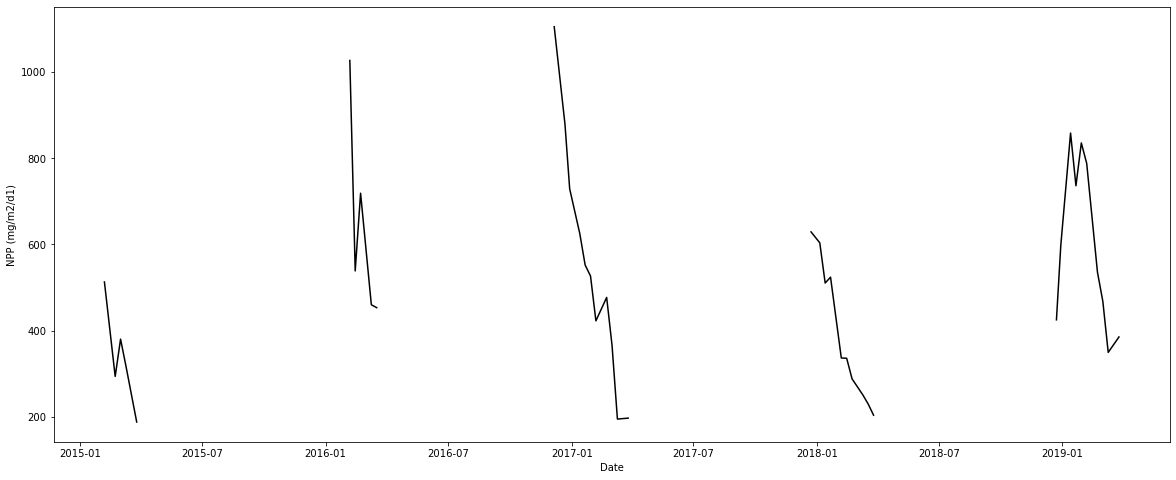

In [164]:
#Plot
fig = plt.subplots(figsize = (20, 8))
plt.plot(sat_date,NPP_atprofiles, c='black')
plt.ylabel('NPP (mg/m2/d1)')
plt.xlabel('Date')

In [174]:
from PyAstronomy import pyasl

In [168]:
# calculate the vertically integrated data column inventory using the composite trapezoidal rule
def integrate(zi, data, depth_range):
    n_profs = len(data)
    zi_start = abs(zi - depth_range[0]).argmin() # find location of start depth
    zi_end =  abs(zi - depth_range[1]).argmin() # find location of end depth
    zi_struct = np.ones((n_profs, 1)) * zi[zi_start : zi_end] # add +1 to get the 200m value
    data = data[:, zi_start : zi_end] # add +1 to get the 200m value
    col_inv = []
    for n in range(0, len(data)):
        col_inv.append(np.trapz(data[n,:][~np.isnan(data[n,:])], zi_struct[n,:][~np.isnan(data[n,:])]))
    return col_inv

In [169]:
# calculate the vertically integrated data column inventory using the composite trapezoidal rule
def integrate_wMLD(zi, data, start_depth, MLD):
    #n_profs = len(data)
    zi_start = abs(zi - start_depth).argmin() # find index of start depth
    zi_end =  abs(zi - MLD).argmin() # find index of end depth
    zi_struct = zi[zi_start : zi_end] # add +1 to get the 200m value
    data = data[zi_start : zi_end] # add +1 to get the 200m value
    col_inv = []
    #for n in range(0, len(data)):
    col_inv.append(np.trapz(data[:][~np.isnan(data[:])], zi_struct[:][~np.isnan(data[:])]))
    return col_inv

In [170]:
def integrate_chl(data):
    # Interpolate/get data set up
    zi = np.arange(0, 2005, 5) # 5 = 400 depth intervals between 0m to 2000m
    #or zi=self.gr["depth"] #which = np.arange(0,2000+dz,dz)
    chl_int = FLOAT.gr["Chl_a"] # interpolated chl values across zi depth intervals for all profiles
    
    ### Using a fixed lower limit
    # Integrate chl - total chl in upper 200m
    upperlim=0
    lowerlim=200
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'] = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated nitrate values between 0m-200m 
    
    ### Using the deepest MLD seen by the float
    # Integrate chl - total chl in upper ML - to deepest MLD seen by float
    upperlim=0
    lowerlim=np.nanmax(FLOAT.gr["mld"])
    print(FLOAT.gr["WMO_code"],"Deepest mixed layer: %1.0f m"%(lowerlim))
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'] = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated nitrate values between 0m-200m 

    ### Using the profile specific MLD
    H2=FLOAT.gr["mld"]
    nz= len(H2)
    # using MLD calculated for each individual profile
    chl_T=chl_int.T # the interpolated chl from FLOAT.gr
    AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'] = np.full( nz, np.nan )
    for i in range(nz): #nz = length H2 (mld array) = number of profiles
        if np.isnan(H2[i]):
            AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'][i] = np.nan # in float used to write code, there were some nan for MLD because of no salinity values recorded
        else:
            lowerlim=H2[i]
            data=chl_T[i,:]
            AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'][i] = np.array(integrate_wMLD(zi, data, upperlim, lowerlim)) # integrate interpolated nitrate values between 0m-specificMLD
    
    ### The entire water column
    upperlim=0
    lowerlim=2000
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intrWC'] = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated nitrate values between 0m-200m 
    
    return AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'],AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intrWC']
    #or return AllFloats                                      

In [171]:
def chl_underornoice(data,yix):
    H2=FLOAT.gr["mld"]
    nz= len(H2)
    ## How much of the annual chl was present under ice?
    AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno']=np.full(nz, np.nan)
    for i in range(nz):
        test=np.isnan(FLOAT.gr["Chl_a"][0,i]) & np.isnan(FLOAT.gr["Chl_a"][1,i]) & np.isnan(FLOAT.gr["Chl_a"][2,i]) #& np.isnan(FLOAT.gr["Chl_a"][3,i]) #& np.isnan(FLOAT.gr["Chl_a"][4,i]) #& np.isnan(FLOAT.gr["Chl_a"][5,i])
        temp_thres=FLOAT.gr["Temperature"][0:4,i]<(-1.78)
        if test:
            AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]=1
        else:
            AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]=0
    #### Over the whole float timeseries
    ui=np.where(np.isnan(FLOAT.gr["Chl_a"][0,:]) & np.isnan(FLOAT.gr["Chl_a"][1,:]) & np.isnan(FLOAT.gr["Chl_a"][2,:]) & np.isnan(FLOAT.gr["Chl_a"][3,:])) #& np.isnan(FLOAT.gr["Chl_a"][4,i]) #& np.isnan(FLOAT.gr["Chl_a"][5,i])
    ui_tot=np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'][ui])
    nui=np.where(np.isfinite(FLOAT.gr["Chl_a"][0,:]) & np.isnan(FLOAT.gr["Chl_a"][1,:]) & np.isnan(FLOAT.gr["Chl_a"][2,:]) & np.isnan(FLOAT.gr["Chl_a"][3,:])) #& np.isnan(FLOAT.gr["Chl_a"][4,i]) #& np.isnan(FLOAT.gr["Chl_a"][5,i])
    nui_tot=np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'][test])
    #print(np.nansum(chl_intr_dMLD))
    #print('approx % of chl under ice during float timeseries:', round(ui_tot/nui_tot*100,2),'%')
    
    #### get index for profiles that are in austral year, under ice and ice free
    AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]=[]
    AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]=[]
    AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]=[]
    for i in range(len(FLOAT.gr["date_dt"])):
        decy = pyasl.decimalYear(FLOAT.gr["date_dt"][i]) #might be more efficient to make decy an np.int_ here so all the logical queries can be called at once?...
        smol=decy>=(yix-0.5)
        tol=decy<(yix+0.5)
        underice=AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]>0
        icefree=AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]==0
        if smol==tol:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"],np.int_(i))
        if smol==tol==underice:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"],i)
        if smol==tol==icefree:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"],i)
    AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"])
    AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"])
    AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"])
    # pos exlude years with <34 profiles from next lot of calculations?
    ### Calculate how much Chl is present at specific times - whole year, under ice, when there's no ice
    #could add if rule: if len(AllFloats['5904472'][endyear]["aust_ix"])<34: continue... or [] =np.nan
    #### Total in austral year
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]]),6)
    #### Total under ice
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_underice_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]]),6)
    #### Total when ice-free
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_icefree_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]]),6)
    #### proportion under ice for austral year
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_underice"]=AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_underice_chl"]/AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_icefree"]=AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_icefree_chl"]/AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]
    #### Mean [Chl] in WC
    #AllFloats['5904472'][yix]["Mean_aus_chl"]=np.round(np.nanmean(chl_intrWC[AllFloats['5904472'][yix]["aust_ix"]]),6)
    #for yix in range(startyear,endyear+1,1):
    print(yix,"under ice",np.round(AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_underice"],3))
    #for yix in range(startyear,endyear+1,1):
    #    print(yix,"ice free",np.round(AllFloats['5904472'][yix]["Prop_icefree"],3))
    
    #return AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'],AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"],AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"],AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_underice_chl"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_icefree_chl"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_underice"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_icefree"]
    return AllFloats

In [172]:
def nosat_chl(data,yix):
    ## What is happening to the chl when the satellite isn't seeing the ice-free waters (from ~mid March)?
    Mar3015=datetime.datetime(2015,3,30)
    decmar15=pyasl.decimalYear(Mar3015)
    Mar2116=datetime.datetime(2016,3,21)
    decmar16=pyasl.decimalYear(Mar2116)
    Mar2217=datetime.datetime(2017,3,22)
    decmar17=pyasl.decimalYear(Mar2217)
    Mar1418=datetime.datetime(2018,3,14)
    decmar18=pyasl.decimalYear(Mar1418)
    Mar1419=datetime.datetime(2019,3,14)
    decmar19=pyasl.decimalYear(Mar1419)
    Mar2120=datetime.datetime(2020,3,21)
    decmar20=pyasl.decimalYear(Mar2120)

    AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]=[]
    for i in range(len(FLOAT.gr["date_dt"])):
        decy = pyasl.decimalYear(FLOAT.gr["date_dt"][i])
        smol=decy>=(yix-0.5)
        tol=decy<(yix+0.5)
        icefree=AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]==0
        if yix==2015:
            mar=decy>decmar15
        elif yix==2016:
            mar=decy>decmar16
        elif yix==2017:
            mar=decy>decmar17
        elif yix==2018:
            mar=decy>decmar18
        elif yix==2019:
            mar=decy>decmar19
        elif yix==2020:
            mar=decy>decmar20
        elif yix==2021:
            continue
        if smol==tol==icefree==mar:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"],i)
        AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"])
    
    #could add if rule: if len(AllFloats['5904472'][endyear]["aust_ix"])<34: continue... or [] =np.nan
    #### Total chl when satellite field of view reduces during March, but before ice returns
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_nosat_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]]),6)
    #### proportion under ice for austral year
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_nosat"]=AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_nosat_chl"]/AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]
    print(yix,"no satellite coverage",np.round(AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_nosat"],3))
    return AllFloats

In [175]:
#make structure for floats 
AllFloats = {}

for f_ix in range(0,len(files)):
    #FLOAT = grids_one_buoy(files[f_ix],display_info = False, DO_ml_crit = 2.5, clear_short = True)
    AllFloats[FLOAT.gr["WMO_code"]] = {}
    AllFloats[FLOAT.gr["WMO_code"]]['dates_dt']=FLOAT.gr["date_dt"]
    #upperlim=0
    #lowerlim=np.nanmax(FLOAT.gr["mld"])
    #print(FLOAT.gr["WMO_code"],"Deepest mixed layer: %1.0f m"%(lowerlim))
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'],AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intrWC']=integrate_chl(FLOAT)
    
    ##### Get year range
    startyear=FLOAT.gr["date_dt"][0].year
    endyear=FLOAT.gr["date_dt"][-1].year
    #print(startyear, '-', endyear)
    for yix in range(startyear,endyear+1,1):
        AllFloats[FLOAT.gr["WMO_code"]][yix] ={}
        AllFloats=chl_underornoice(FLOAT,yix)
        AllFloats=nosat_chl(FLOAT,yix)

#display(AllFloats)

5904472 Deepest mixed layer: 145 m
2015 under ice 0.172
2015 no satellite coverage 0.074
2016 under ice 0.167
2016 no satellite coverage 0.057
2017 under ice 0.047
2017 no satellite coverage 0.017
2018 under ice 0.128
2018 no satellite coverage 0.165
2019 under ice 0.126
2019 no satellite coverage 0.291


In [196]:
#chl_plot=AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200']
chl=AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200']
date=AllFloats[FLOAT.gr["WMO_code"]]['dates_dt']

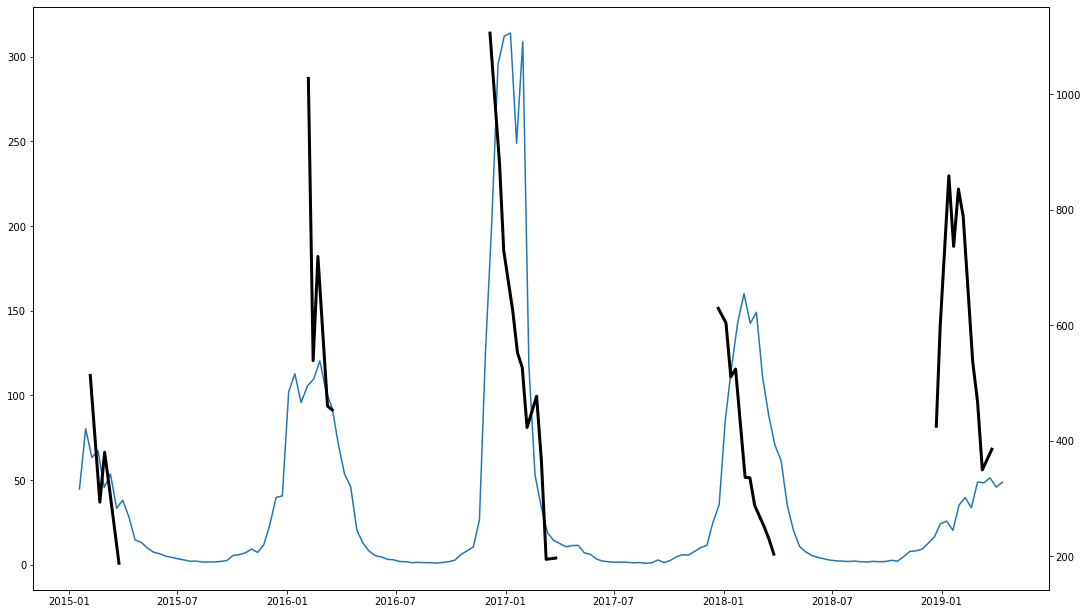

In [197]:
fig = plt.figure(figsize = (30,30))
ax0 = fig.add_axes([0.07,0.65,0.47,0.27])
ax0.plot(date,chl_plot)
ax1=ax0.twinx()
ax1.plot(sat_date,NPP_atprofiles, c='black',linewidth=3)